# Using Amazon SageMaker with Public Datasets

__*Clustering Gene Variants into Geographic Populations*__


## Introduction

Amazon SageMaker allows you to bring powerful machine learning workflows to data that is already in the cloud.  In this example, we will do just that - combining Amazon SageMaker with data from the [1000 Genomes Project] which is hosted by AWS as a [public dataset].  Specifically, we will perform unsupervised learning using Amazon SageMaker's KMeans algorithm to see if we can predict the geographic population for a set of single nucleotide polymorphisms.

Single nucleotide polymorphisms or SNPs (pronounced "snips") are single base-pair changes to DNA.  DNA is a long chain molecule that is used to store the "source code" for all living organisms and is read as a sequence of four letters -- A, T, C, and G -- that are called "bases".  SNPs occur when a base in the sequence changes due to environmental causes or random replication errors during cell division in germ cells (eggs and sperm).  Sometimes these changes are harmless, and sometimes they can cause serious diseases.

In this notebook we'll use k-means to cluster SNPs found in Chromosomes 1-22 (excluding the sex chromosomes X and Y) across the population represented in the 1000 Genomes dataset.

[1000 Genomes Project]: https://aws.amazon.com/1000genomes/
[public dataset]: https://aws.amazon.com/public-datasets/

## Setup

### Data sources
We can get variant call data (which describes SNPs, and other kinds of DNA sequence modifications) from the publicly hosted 1000 Genomes dataset on AWS.  We need the "\*.vcf" files corresponding to Chromosomes 1-22 from the 20130502 release of the data.

In [1]:
!aws s3 ls --human-readable s3://1000genomes/release/20130502/ | grep -P "chr\d+.*vcf\.gz$"

2015-06-03 19:43:52    1.1 GiB ALL.chr1.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz
2015-06-03 19:45:05  737.9 MiB ALL.chr10.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz
2015-06-03 19:43:47  731.5 MiB ALL.chr11.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz
2015-06-03 19:43:49  706.5 MiB ALL.chr12.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz
2015-06-03 19:45:08  531.0 MiB ALL.chr13.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz
2015-06-03 19:44:44  483.1 MiB ALL.chr14.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz
2015-06-03 19:44:24  436.7 MiB ALL.chr15.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz
2015-06-03 19:43:46  472.2 MiB ALL.chr16.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz
2015-06-03 19:43:45  414.5 MiB ALL.chr17.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz
2015-06-03 19:45:19  416.2 MiB ALL.chr18.phase3

Even gz compressed, these files can be over 1GB in size.  They contain a lot of information that we're not going to use in this exercise, so we need to do a little filtering.  We'll also need to some transformation of the data so that it can be fed to the Amazon Algorithm for K-Means clustering.

For each chromosome's VCF we'll do the following:

1. select biallelic SNPs with a frequency of 30% using a tool called [bcftools] (v1.9)
2. select the first 100 positional SNPs and export a CSV file with a `python` script

We can do the above in a scalable and parallel fashion using AWS Batch.  Each of the above steps has been containerized such that they can read and write data __*directly on S3*__.  This is ideal for cases common in genomics where the source and output data can be very large and infeasible to transfer.

[bcftools]: http://samtools.github.io/bcftools/

In the interest of time, we've already done the heavy lifting here

In [2]:
!aws s3 ls s3://reinvent-2018-wps201/data/ | grep -P "chr\d+.*freq30.*csv"

2018-11-21 17:20:39     522126 chr1.freq30.biallelic.snps.first100.csv
2018-11-21 17:20:39     522185 chr10.freq30.biallelic.snps.first100.csv
2018-11-21 17:20:40     522241 chr11.freq30.biallelic.snps.first100.csv
2018-11-21 17:20:41     522209 chr12.freq30.biallelic.snps.first100.csv
2018-11-21 17:20:42     522441 chr13.freq30.biallelic.snps.first100.csv
2018-11-21 17:20:44     522441 chr14.freq30.biallelic.snps.first100.csv
2018-11-21 17:20:44     522441 chr15.freq30.biallelic.snps.first100.csv
2018-11-21 17:20:45     522214 chr16.freq30.biallelic.snps.first100.csv
2018-11-21 17:20:46     522121 chr17.freq30.biallelic.snps.first100.csv
2018-11-21 17:20:47     522180 chr18.freq30.biallelic.snps.first100.csv
2018-11-21 17:20:49     522240 chr19.freq30.biallelic.snps.first100.csv
2018-11-21 17:20:49     522122 chr2.freq30.biallelic.snps.first100.csv
2018-11-21 17:20:49     522223 chr20.freq30.biallelic.snps.first100.csv
2018-11-21 17:20:51     522341 chr21.freq30.biallelic.snps.first10

#### For the curious
if you want to give it a try on your own, the `submit_jobs.py` script found with this notebook will execute the Batch jobs needed and output the data to your own S3 bucket.  Simply open a terminal via Jupyter and run the following:

```
$ cd ~/SageMaker/wps201
$ python ./submit_jobs.py
```

## The Modeling Problem

### Data Background

The data comes from human genome sequences.  Humans have 23 pairs of chromosomes, and hence are "diploid" - meaning they should have two copies of any given DNA sequence (with a couple exceptions - e.g. genes in the XY chromosomes).

A variant in a copy of a DNA sequence is called an "allele".  At minimum, there is at least one allele - the DNA sequence that matches the human reference genome.  Alleles that do not match the reference are called "alternates".

A genotype is a combination of variants for a DNA sequence position, over all copies.  For example, let's say that the reference for a DNA position is 'A', and a variant for the position is 'T'.  The possible genotypes for this position would be:

* A/A = REF / REF - "homozygous" for the reference
* A/T = REF / ALT - "heterozygous"
* T/A = ALT / REF - "heterozygous"
* T/T = ALT / ALT - "homozygous" for the alternate

Typical genotype calls use integer IDs to represent the REF and ALT alleles, with REF always being '0'.  Alternative alleles start at '1' and count up to the total number of alternative alleles for the variant.  So the possible genotypes for the example above would be:

* 0 / 0
* 0 / 1
* 1 / 0
* 1 / 1

In cases where there is more than one alternate allele, you might see genotypes like '0 / 2' or '1 / 2'.

In the CSV files above, the filtered genotypes have been converted to numerical values to make them compatible with machine learning algorithms.

In this case there are three distinct values that correspond to the number of alternate allel copies a sample sequence has.

* 0 / 0 = 0
* 0 / 1 = 1
* 1 / 0 = 1
* 1 / 1 = 2



### Feature selection
For this modeling exercise, we are going to use a "variant ID" - a combination of the chromosome position, the reference allele, and the alternative allele - as labels for SNP features and the numeric genotypes described above as values for K-Means clustering.  In any given chromosome there can be 1000s of SNPs.  We want to reduce this down to a more manageable set, which can improve our clustering performance.

The data processing pipeline in AWS Batch has reduced this to a more manageable set of 100 biallelic SNPs per chromosome for chromosomes 1-22, yielding 2200 features to cluster on.

### Data transformation


Let's read in the panel metadata to get class labels - the geographic location that each sample originated from. Here we'll use `pandas` to process the metadata panel into classes we can use:

In [3]:
import pandas as pd

# pandas can read data directly from S3!
classes = pd.read_table(
    's3://1000genomes/release/20130502/integrated_call_samples_v3.20130502.ALL.panel', 
    usecols=['sample', 'pop', 'super_pop']
)
classes.sample(10)

,sample,pop,super_pop
766,HG02058,KHV,EAS
1111,HG02878,GWD,AFR
826,HG02178,CDX,EAS
1015,HG02634,GWD,AFR
174,HG00372,FIN,EUR
624,HG01801,CDX,EAS
55,HG00171,FIN,EUR
302,HG00739,PUR,AMR
2375,NA20798,TSI,EUR
1255,HG03279,ESN,AFR


Let's see how the data is distributed across each of the populations and super populations:

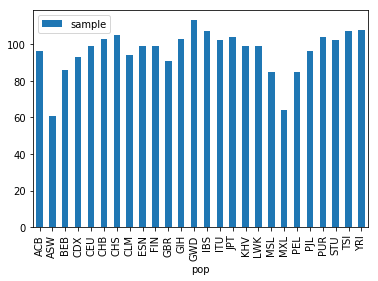

In [4]:
%matplotlib inline
classes.groupby('pop').count().reset_index().drop(columns='super_pop').plot.bar('pop')

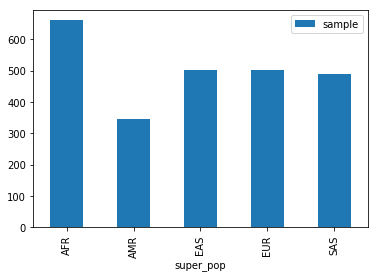

In [5]:
classes.groupby('super_pop').count().reset_index().drop(columns='pop').plot.bar('super_pop')

Based on the charts above, there are 26 reported geographic populations and 5 super-populations in the data.  The distribution of samples across these populations looks reasonable - i.e. each group has roughly the same number of samples.

Let's now create the data frame to feed into model training. To do this we'll collect the SNP counts for each chromosome from the processing pipeline into one dataframe, and merge it with the population annotations which will be used as labels.

In [6]:
# read and aggregate SNP data from each chromosome
import os
import re
from functools import reduce

import boto3
import pandas as pd


s3 = boto3.resource('s3')

bucket_name = 'reinvent-2018-wps201'
prefix = 'data'
pattern = 'chr[0-9]+.*?freq30.*first100.*csv'

bucket = s3.Bucket(bucket_name)
source_files = (
    pd.read_csv(s3.Object(bucket_name, o.key).get()['Body'])
    for o in bucket.objects.filter(Prefix=prefix)
    if re.search(pattern, o.key)
)

initial_value = next(source_files).set_index('features')

result = reduce(lambda x,y: pd.concat((x, y.set_index('features'))), source_files, initial_value)

data = result.transpose()
data.index.name = 'sample'
data.reset_index(inplace=True)

data = classes.merge(data, on='sample')
data.sample(10)

,sample,pop,super_pop,1-14930-A-G,1-15211-T-G,1-15820-G-T,1-18849-C-G,1-30923-G-T,1-49298-T-C,1-52238-T-G,...,9-106203-C-T,9-107536-C-T,9-108706-A-G,9-108998-A-G,9-109859-C-T,9-109860-C-G,9-109891-T-A,9-110586-C-G,9-110899-A-G,9-112882-A-G
901,HG02356,CDX,EAS,1,2,2,2,2,2,2,...,1,2,2,2,1,1,2,2,2,2
201,HG00448,CHS,EAS,2,1,0,2,2,2,2,...,0,0,0,0,0,0,0,0,0,0
1243,HG03238,PJL,SAS,1,1,1,2,1,2,2,...,1,1,1,1,1,1,1,1,1,1
1657,NA06985,CEU,EUR,1,1,1,2,2,2,2,...,1,2,1,1,1,1,1,1,2,1
850,HG02239,IBS,EUR,1,1,1,2,1,2,2,...,1,2,2,1,1,1,1,1,2,2
853,HG02253,PEL,AMR,1,1,0,2,2,0,2,...,0,0,0,0,1,1,1,1,1,1
177,HG00376,FIN,EUR,2,2,0,2,2,2,2,...,1,2,1,0,2,2,2,2,2,1
563,HG01630,IBS,EUR,1,1,1,2,2,2,2,...,1,1,2,2,1,1,1,1,2,2
937,HG02429,ACB,AFR,1,1,0,2,1,0,2,...,1,2,2,1,1,1,2,2,2,1
1975,NA19012,JPT,EAS,1,0,2,2,2,1,2,...,1,1,1,1,1,1,1,1,1,1


## Training
This dataset is small, only 2504 observations, but should give an idea of how to use the built-in KMeans algorithm.

To prepare for training, we need to remove all non-numeric values, so below we'll drop the `pop` field from the data and store it as labels we can use later. 

In [7]:
from math import ceil, floor

train_data = data.copy()
train_labels = train_data[['sample', 'pop', 'super_pop']].copy().set_index('sample')
train_labels['pop'] = pd.Categorical(train_labels['pop'])
train_labels['super_pop'] = pd.Categorical(train_labels['super_pop'])
train_data = train_data.drop(columns=['pop', 'super_pop']).set_index('sample')

Here's the standard setup for SageMaker training using KMeans.

Be sure to set the `bucket` name to something you have access to.
The fitting process will upload the training data to this bucket for the training instance(s) to access.  Once training is done, a model artifact will be uploaded to the bucket.

In [8]:
from sagemaker import KMeans, get_execution_role, Session

session = Session()
role = get_execution_role(sagemaker_session=session)
bucket = 'wps201-s3stack-xb42fe9pfjwa-s3bucket-1xgpna0lcpp1k'  ## per user bucket here

data_location = 's3://{}/sagemaker/genome-kmeans/data'.format(bucket)
output_location = 's3://{}/sagemaker/genome-kmeans/output'.format(bucket)

print(role)
print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))

arn:aws:iam::763766227043:role/service-role/wps201-IamStack-QIAZ0YG9XQBE-AmazonSageMaker-ExecutionRole
training data will be uploaded to: s3://wps201-s3stack-xb42fe9pfjwa-s3bucket-1xgpna0lcpp1k/sagemaker/genome-kmeans/data
training artifacts will be uploaded to: s3://wps201-s3stack-xb42fe9pfjwa-s3bucket-1xgpna0lcpp1k/sagemaker/genome-kmeans/output


K-means clustering algorithms need to have the number of clusters specified upfront.  Some times this is difficult to know beforehand.  In this data, we know that the samples are annotated with 26 populations, and 5 super-populations, but an ideal cluster count could be anywhere between.

Often, choosing a cluster count requires scanning a subset of the data and evaluating a clustering metric (i.e. mean square distance of sample to cluster center), and finding the count that is on an "elbow" of the resultant curve.

In the cloud, we can do this efficiently with the *whole* dataset!

In [9]:
n_clusters = range(2, 41)

# note:
# The service limit 'Number of instances across all training jobs' is 20 Instances
# We're queuing up 39 models in this scan, so we'll need to run in two batches

models = [
    KMeans(
        k=k,
        role=role,
        train_instance_count=1,
        train_instance_type='ml.m4.xlarge',
        epochs=3,
        center_factor=4,
        output_path=output_location,
        data_location=data_location)
    for k in n_clusters]

In [13]:
from time import sleep
from datetime import datetime

import numpy as np


def get_training_job_statuses():
    return pd.Series([
        job['TrainingJobStatus'] 
        for job in session.sagemaker_client.list_training_jobs(MaxResults=20)['TrainingJobSummaries']
    ])


def all_jobs_complete():
    return all(get_training_job_statuses() == 'Completed')


training_jobs = []
for batch_num, batch in enumerate(np.array_split(models,4)):
    for model in batch:
        job_name = 'kmeans-' + datetime.now().strftime('%F-%H-%M-%S-%f')
        model.fit(
            model.record_set(np.float32(train_data.values)), 
            wait=False, logs=False, job_name=job_name)
    
        training_jobs += [job_name]
    print('Waiting for batch {}:'.format(batch_num))
    while not all_jobs_complete():
        print('.', end='')
        sleep(10)

print('\nDone')

INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-05-51-434726
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-05-53-246971
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-05-56-231498
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-05-58-789342
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-06-00-629661
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-06-02-372601
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-06-04-612111
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-06-06-210605
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-06-07-998845
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-06-09-553540


Waiting for batch 0:
......................

INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-09-53-352140
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-09-54-989336
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-10-00-691814
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-10-02-825892
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-10-04-453925
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-10-06-185184
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-10-07-862326
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-10-09-625716
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-10-11-333647
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-10-13-401861


Waiting for batch 1:
.......................

INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-14-07-572328
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-14-09-235080
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-14-11-661325
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-14-14-273692
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-14-15-880069
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-14-17-550344
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-14-19-092000
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-14-21-792440
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-14-23-833676
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-14-27-454628


Waiting for batch 2:
.......................

INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-18-20-895866
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-18-22-714583
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-18-26-587094
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-18-28-302402
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-18-30-259032
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-18-32-121253
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-18-33-922746
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-18-35-689063
INFO:sagemaker:Creating training-job with name: kmeans-2018-11-27-23-18-38-224064


Waiting for batch 3:
.....................
Done


Now lets collect and plot the metrics from our models to see which has a good number of clusters.

In [ ]:
model_k = [int(model.hyperparameters()['k']) for model in models]
model_msd = [
    model.training_job_analytics.dataframe().set_index('metric_name').loc['train:msd', 'value']
    for model in models
]

In [ ]:
from matplotlib.pyplot import plot

plot(model_k, model_msd)

The plot above shows possible "good" cluster counts around 5 and 11.


## Inference Endpoint Deployment

Now, let's deploy the models behind endpoints we can use for predictions.  This process takes about 5-9 mins for each deployment.  Here we'll create endpoints for the models with 5 and 11 clusters.

In [ ]:
%%time

kmeans_predictor_5 = models[model_k.index(5)].deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge')


In [ ]:
%%time

kmeans_predictor_11 = models[model_k.index(11)].deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge')

Let's use our newly deployed inference endpoints to evaluate the models.

The predictors will return a results object from which we can extract the cluster assignments for each sample.  We can pass the original training data into a predictor to get cluster assignments for each sample.  To be performant, we'll pass the data to an inference endpoint in batches.

In [ ]:
from itertools import chain, zip_longest


def chunk(iterable, chunk_size, fillvalue=None):
    return zip_longest(*[iter(iterable)]*chunk_size, fillvalue=fillvalue)


def get_clusters(predictor, train_data, batch_size=200):
    res = [
        predictor.predict(
            np.float32(pd.DataFrame.from_records([
                rec for rec in record 
                if rec is not None
            ]).drop(columns=0))
        ) 
        for record in chunk(train_data.to_records(), batch_size)
    ]

    result = list(chain(*res))
    clusters = np.int0([r.label['closest_cluster'].float32_tensor.values[0] for r in result])
    
    return clusters, result

In [ ]:
clusters_5, result_5 = get_clusters(kmeans_predictor_5, train_data)
clusters_11, result_11 = get_clusters(kmeans_predictor_11, train_data)

Let's see how these predicted clusters map to the real classes

In [ ]:
pd.crosstab(
    train_labels['pop'], 
    columns=clusters_5, 
    colnames=['cluster']
).reset_index(
).merge(
    train_labels.reset_index()[['pop', 'super_pop']].drop_duplicates(), 
    on='pop'
).groupby(
    'super_pop'
).sum()

In [ ]:
pd.crosstab(
    train_labels['pop'], 
    columns=clusters_11, 
    colnames=['cluster']
).reset_index(
).merge(
    train_labels.reset_index()[['pop', 'super_pop']].drop_duplicates(), 
    on='pop'
).groupby(
    'super_pop'
).sum()

From these cross tabulations we see that there are clusters with majority membership in each of our super-populations.  Having more clusters spreads populations out (e.g. AMR and SAS).

## Visualizing the results

What do the clusters look like visually?  To answer this question, we'll generate a force weighted graph of the clusters and color code them by their original population code.

To accomplish this, we'll use the [lightning-viz](http://lightning-viz.org/) package for Python.  If this notebook was created via CloudFormation, the package should already be installed in the environment.  Otherwise, you can run:

```
!pip install lightning-python
```

in a new cell before the cell below.

In [ ]:
from lightning import Lightning

lgn = Lightning(ipython=True, local=True)

def get_cluster_graph(result, labels):
    graph_data = [
        {
            'cluster': int(r.label['closest_cluster'].float32_tensor.values[0]),
            'distance': float(r.label['distance_to_cluster'].float32_tensor.values[0])
        }
        for r in result
    ]

    gg = pd.concat(
        (labels.reset_index(), 
         pd.DataFrame(graph_data)),
        axis=1
    )
    gg['code'] = pd.np.NaN  # place holder for population category codes
    
    centers = sorted(gg['cluster'].unique())

    gg = pd.concat(
        (pd.DataFrame({  # this dataframe is for the cluster centers
            'cluster': centers, 
            'distance': 0, 
            'sample': list(map(str, centers)), 
            'pop': '',
            'super_pop': ''
        }), gg)).reset_index().drop(columns='index')
    gg['code'] = pd.Categorical(gg['super_pop']).codes


    # generate the network links and plot
    nn = [(r[0], r[1], r[2]) for r in gg.to_records()]
    
    return nn, gg

### Data with 5 Clusters

In [ ]:
nn, gg = get_cluster_graph(result_5, train_labels)
lgn.force(nn, group=gg['code'], labels=gg['sample'] + ' ' + gg['pop'] + ':' + gg['super_pop'])

### Data with 11 Clusters

In [ ]:
nn, gg = get_cluster_graph(result_11, train_labels)
lgn.force(nn, group=gg['code'], labels=gg['sample'] + '\n' + gg['pop'] + ':' + gg['super_pop'])

## Bottom Line

The African (AFR) and East Asian (EAS) super-populations produce good clusters.

The mixture of populations in the clusters may be interpretted as individuals with mixed ancestry or possibly immigration.  Also, the clustering could be improved further if there was additional dimensionality reduction (e.g. via PCA), more samples, or both.

### (Optional) Delete the Endpoint(s)
If you're ready to be done with this notebook, make sure run the cell below.  This will remove any hosted endpoints you created and avoid any charges from unused resources.

In [ ]:
kmeans_predictor_5.delete_endpoint()
kmeans_predictor_11.delete_endpoint()